In [1]:
import os
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageOps
import numpy as np
from IPython.display import display
import IPython.display
import matplotlib.pyplot as plt
import json
from utils import Config

In [2]:
config = Config()

In [3]:
def clear_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)
    else:
        print(f'Cleaning "{config.dataset_path}"')
        removed = 0
        
        for fn in os.listdir(config.dataset_path):
            if fn.endswith(".png") or fn.endswith(".json"):
                os.remove(os.path.join(config.dataset_path, fn))
                removed += 1
    
        print(f'Removed {removed} samples under "{config.dataset_path}"')

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        # for i in range(size):
        #     images.append([0] * rows * cols)
            
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 118 ms, sys: 70.9 ms, total: 189 ms
Wall time: 189 ms


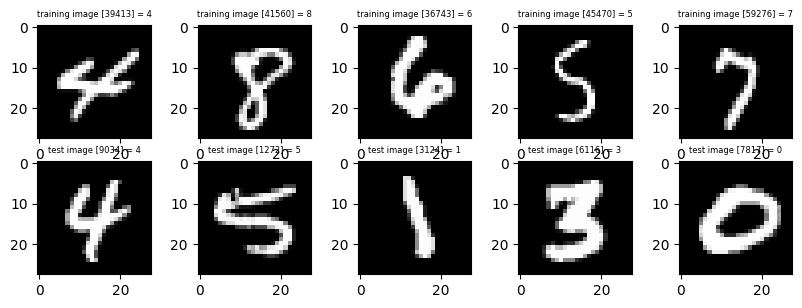

In [6]:
%%time
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [7]:
clear_dataset_folder()
image_indices = np.arange(len(x_train))
np.random.shuffle(image_indices)
image_indices = image_indices[:config.dataset_sample_count]
metadata = {}

for i in tqdm(image_indices):
    img_data = x_train[i]
    img_label = y_train[i]

    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        img = img.resize((config.sample_size, config.sample_size))
        # img = img.point(lambda x: 255 if x > 50 else 0)
        sample_img_fname = f'train_{i:05d}_{img_label}.png'

        if sample_img_fname in metadata:
            continue
            
        img.save(os.path.join(config.dataset_path, sample_img_fname), format='png')
        metadata[sample_img_fname] = dict(origin='', value=str(img_label))

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name), 'w') as f:
    json.dump(metadata, f, indent=0)

print(f'{len(metadata)} samples generated')

Cleaning "dataset"
Removed 0 samples under "dataset"


  0%|          | 0/10000 [00:00<?, ?it/s]

10000 samples generated
